<a href="https://colab.research.google.com/github/lsprietog/public_release/blob/main/demo_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# @title 1. Setup Environment
# Clone the repository to access the source code
!git clone https://github.com/lsprietog/public_release.git
%cd public_release

# Install dependencies
!pip install -r requirements.txt

Cloning into 'public_release'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 29 (delta 5), reused 27 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 58.04 KiB | 4.14 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/public_release
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.1 MB/s eta 0:00:00


In [4]:
# @title 2. Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add src to path to import our modules
sys.path.append(os.path.abspath('src'))

from ml_models import IVIMRegressor
from ivim_model import calculate_ivim_params

In [5]:
# @title 3. Generate Synthetic Data
def generate_synthetic_training_data(n_samples=2000):
    print(f"Generating {n_samples} synthetic samples...")

    # Typical clinical b-values
    b_values = np.array([0, 10, 20, 30, 50, 80, 100, 200, 400, 800, 1000])

    # Random parameters within physiological ranges
    D = np.random.uniform(0.0005, 0.003, n_samples)      # Diffusion coefficient
    f = np.random.uniform(0.05, 0.3, n_samples)          # Perfusion fraction
    D_star = np.random.uniform(0.005, 0.05, n_samples)   # Pseudo-diffusion
    K = np.random.uniform(0, 1.5, n_samples)             # Kurtosis

    X = []
    for i in range(n_samples):
        # Signal model: S = S0 * (f * exp(-b*D*) + (1-f) * exp(-b*D + K_term))
        term_diff = np.exp(-b_values * D[i] + (1/6) * (b_values**2) * (D[i]**2) * K[i])
        term_perf = np.exp(-b_values * D_star[i])
        S0 = 1000
        signal = S0 * (f[i] * term_perf + (1 - f[i]) * term_diff)

        # Add Rician/Gaussian noise
        noise = np.random.normal(0, 0.02 * S0, size=len(b_values))
        signal_noisy = signal + noise
        signal_noisy[signal_noisy < 0] = 0

        # Normalize signal
        signal_norm = signal_noisy / np.max(signal_noisy)
        X.append(signal_norm)

    return np.array(X), D, f, D_star, K, b_values

X, D_true, f_true, D_star_true, K_true, b_values = generate_synthetic_training_data()

Generating 2000 synthetic samples...


In [6]:
# @title 4. Train Machine Learning Model
# We will train an Extra Trees Regressor to predict the Diffusion Coefficient (D)

print("Initializing Extra Trees Regressor...")
model_D = IVIMRegressor(model_type='extra_trees', params={'n_estimators': 100})

print("Training model...")
# Train on 80% of the data, validate on 20%
metrics = model_D.train(X, D_true, test_size=0.2)

print("\nTraining complete!")

Initializing Extra Trees Regressor...
Training model...
Training extra_trees on 1600 samples...
--- Validation Metrics ---
MAE: 0.000176
MSE: 0.000000
RMSE: 0.000229
R2: 0.899083

Training complete!


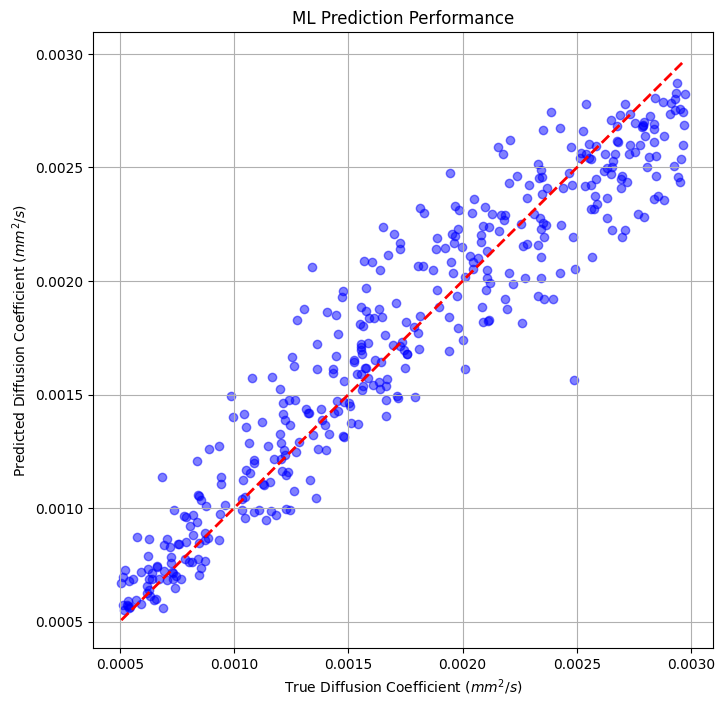

In [7]:
# @title 5. Visualize Predictions
# Let's look at the correlation between True and Predicted values for the test set

from sklearn.model_selection import train_test_split
_, X_test, _, y_test = train_test_split(X, D_true, test_size=0.2, random_state=42)
y_pred = model_D.predict(X_test)

plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('True Diffusion Coefficient ($mm^2/s$)')
plt.ylabel('Predicted Diffusion Coefficient ($mm^2/s$)')
plt.title('ML Prediction Performance')
plt.grid(True)
plt.show()